# CNN 
https://www.youtube.com/watch?v=doT7koXt9vw&list=PL5TJqBvpXQv6cd1kade4kjwr8_QQj8j3k&index=3

### IMPORTS

In [1]:
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm
from torch import nn
from torchsummary import summary
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader

### DATALOADER

In [2]:
DATA_DIR = '/home/diogo/Documentos/IC/CNN'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

tensor_train = CIFAR10(DATA_DIR, train=True, download=True,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=True,
                         transform=prep_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 64

train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

### MODEL

In [5]:
class CNN_net(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 100)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [7]:
cnn_model = CNN_net().to(device)

In [8]:
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 32, 13, 13]           4,640
              ReLU-5           [-1, 32, 13, 13]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Linear-7                  [-1, 256]         295,168
              ReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 100]          25,700
Total params: 325,956
Trainable params: 325,956
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 1.24
Estimated Total Size (MB): 1.60
-------------------------------------------

In [9]:
cnn_loss_func = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001)

### TRAINING

In [14]:
def plot_loss(train_losses, test_losses):
    fig = plt.figure(figsize=(13,5))
    ax = fig.gca()
    ax.plot(train_losses, label="Train loss", color = "green")
    ax.plot(test_losses, label="Test loss", color = "purple")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16");
    plt.show()

Epoch 0/50: 100%|██████████| 782/782 [00:23<00:00, 33.71it/s]


Epoch: 0; Train Loss: 1.9697906545665869


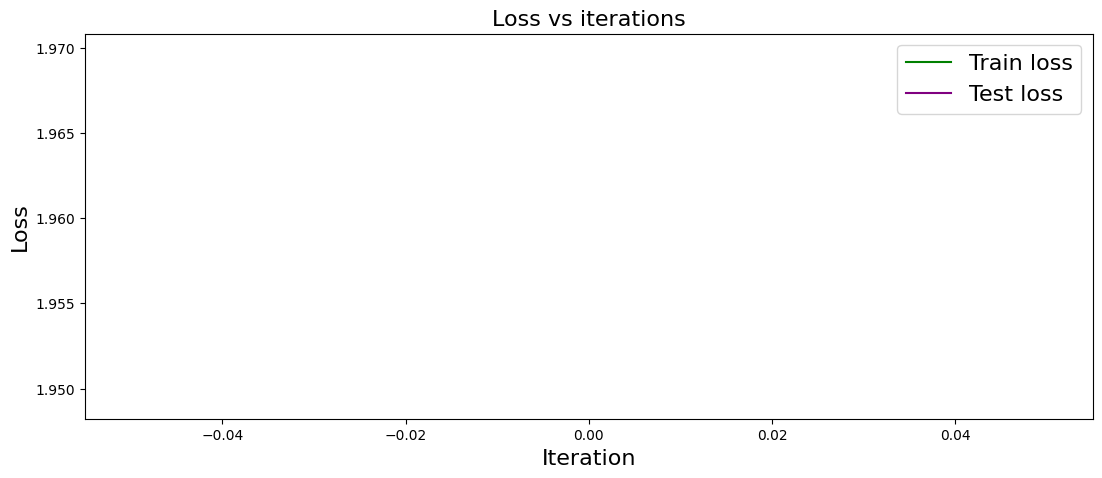

Epoch 10/50: 100%|██████████| 782/782 [00:28<00:00, 27.05it/s]


Epoch: 10; Train Loss: 1.5708113669434471


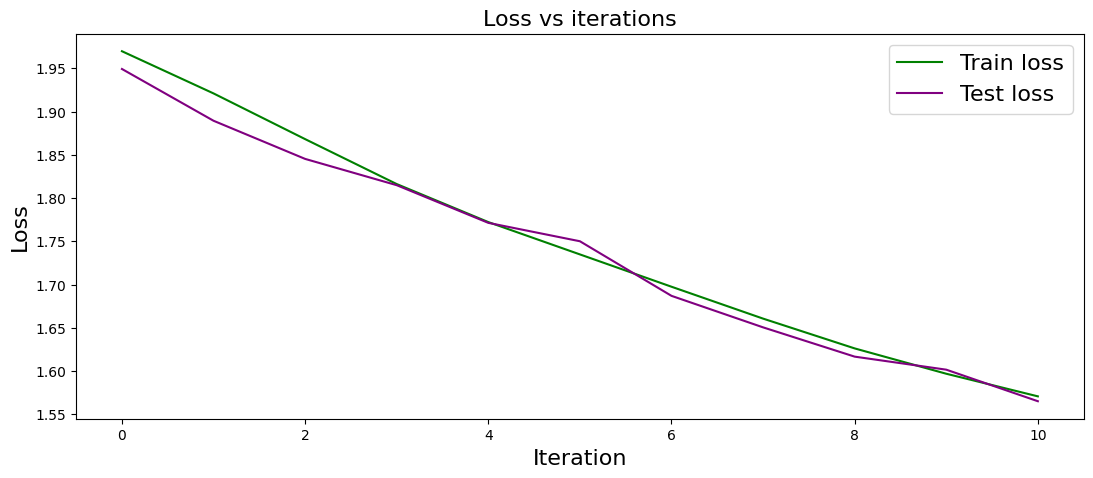

Epoch 20/50: 100%|██████████| 782/782 [00:26<00:00, 29.17it/s]


Epoch: 20; Train Loss: 1.4123799569161652


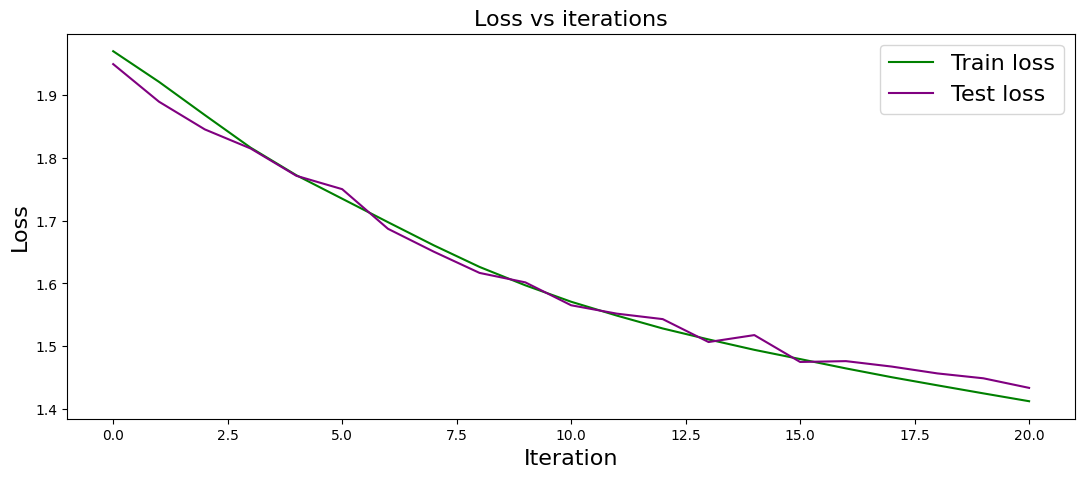

Epoch 30/50: 100%|██████████| 782/782 [00:29<00:00, 26.93it/s]


Epoch: 30; Train Loss: 1.2953224889457684


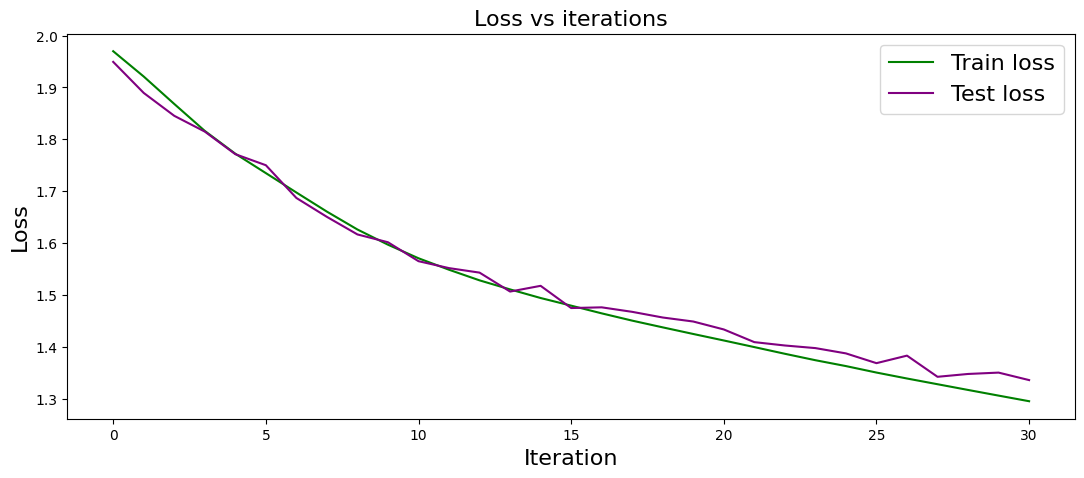

Epoch 40/50: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Epoch: 40; Train Loss: 1.2052949354471758


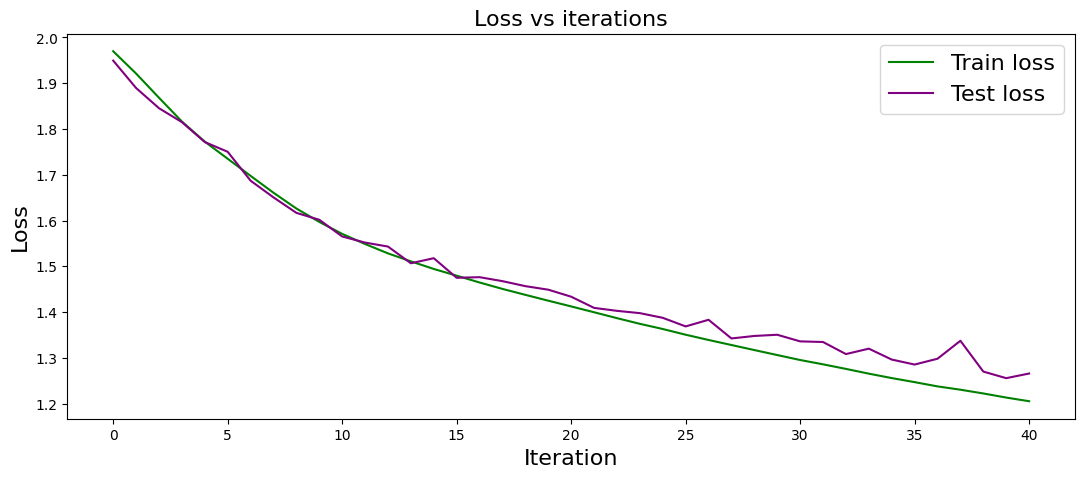

Epoch 50/50: 100%|██████████| 782/782 [00:29<00:00, 26.07it/s]


Epoch: 50; Train Loss: 1.134898214465212


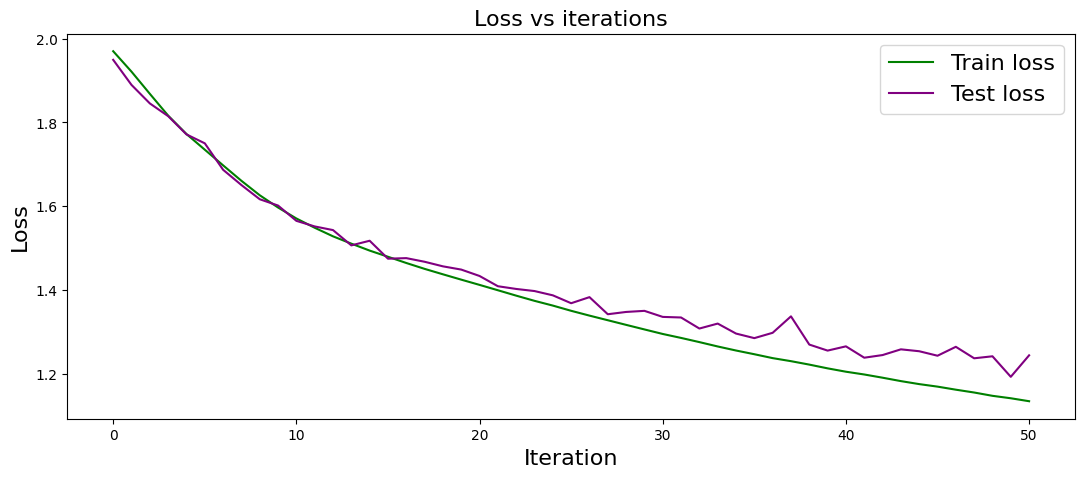

In [15]:

epochs = 51
conv_train_losses = []
conv_test_losses = []

for t in range(epochs):
    
    train_loss = 0.0
    test_loss = 0.0

    for img, label in tqdm(train_loader, desc=f'Epoch {t}/{epochs-1}'):
        
        cnn_optimizer.zero_grad()
        
        img,label = img.to(device) ,label.to(device)
        
        pred = cnn_model(img)
        loss = cnn_loss_func(pred, label)
        loss.backward()
        cnn_optimizer.step()
        
        train_loss += loss.item()
        
    train_loss = train_loss/len(train_loader)
    conv_train_losses.append(train_loss)
    
    with torch.no_grad():
        for img, labels in test_loader:
            
            img, labels = img.to(device), labels.to(device)

            pred = cnn_model(img)
            loss = cnn_loss_func(pred, labels)
            test_loss += loss.item()
        
    test_loss = test_loss / len(test_loader)
    conv_test_losses.append(test_loss)
    
    if t % 10 == 0:
        print(f"Epoch: {t}; Train Loss: {train_loss}")
        if t != 0:
            plot_loss(conv_train_losses,conv_test_losses)